<a href="https://www.kaggle.com/code/lorresprz/leaf-diseases-classification-inceptionv3-network?scriptVersionId=145311999" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython.display import clear_output
import tensorflow_hub as hub

# Loading dataset 

The data loading/processing/augmentation/displaying follows the code from this notebook:

https://www.kaggle.com/code/zadosaadipurwanto/resnet50-v2-classification

In this notebook, we will use Inception-V3 instead of ResNet50 to perform the classification. In adopting the same processing/displaying format as the above notebook, we can compare the obtained result using InceptionV3 with that of ResNet50. 

In [3]:
train_data_dir = '/kaggle/input/soybean-diseased-leaf-dataset'
BATCH_SIZE = 20
IMG_SIZE = (224, 224)
EPOCHS = 30
SHUFFLE_BUFFER = 1000
validation_split = 0.15 

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split, 
    subset='training',  
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    seed=101,
    validation_split=validation_split,  
    subset='validation',  
)

Found 701 files belonging to 10 classes.
Using 596 files for training.
Found 701 files belonging to 10 classes.
Using 105 files for validation.


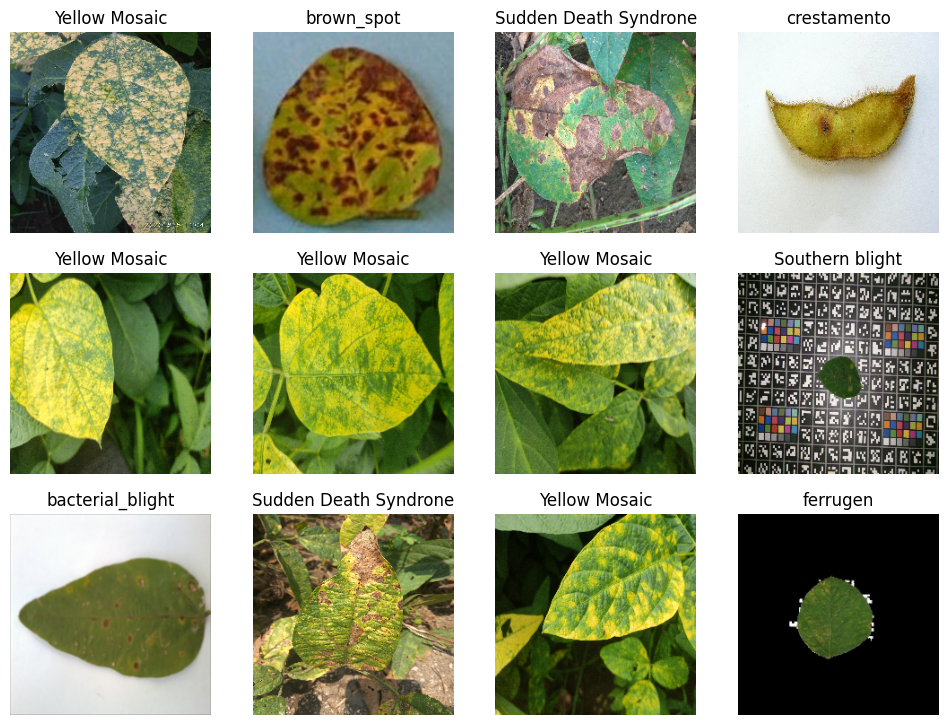

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(12):
        image = images[i].numpy()  
        label = labels[i]
        class_name = class_names[tf.argmax(label)]
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.astype("uint8"))  
        plt.title(class_name)
        plt.axis("off")  
plt.show()

## Data augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.Rescaling(1/255.)
])
normalization = layers.Rescaling(1/255.)

In [7]:
training_data = (train_dataset.map(lambda x,y: (data_augmentation(x), y))
                 .shuffle(SHUFFLE_BUFFER).prefetch(1).cache())
validation_data = (validation_dataset.map(lambda x,y: (normalization(x), y))
                   .prefetch(1).cache())   

# Loading Inception-V3 model

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

In [9]:
#use all except for the last layer (specific to the 'imagenet' competition)
pretrained_model = InceptionV3(input_shape = (224, 224,3), 
                              include_top = False,
                              weights = 'imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [10]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.ckpt',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4,
        restore_best_weights=True
    ),
]

In [11]:
#make all layer in the pretrained Inception-V3 non-trainable 
for layer in pretrained_model.layers:
    layer.trainable = False

In [12]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(250, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 250)               512250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2510      
                                                             

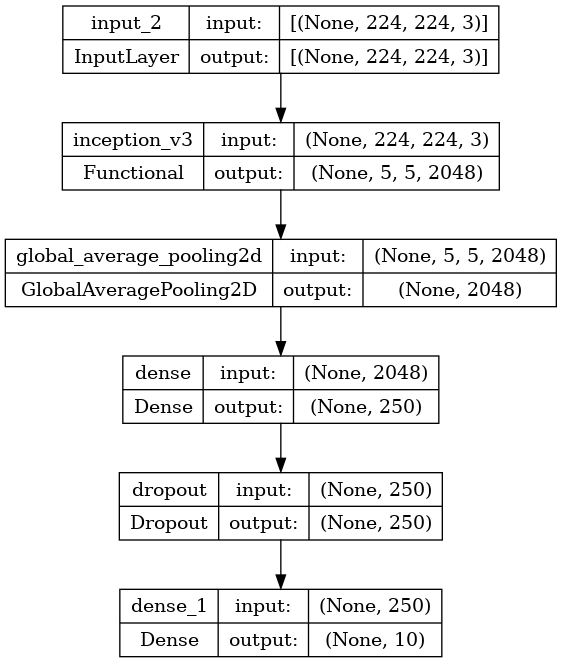

In [13]:
plot_model(model, show_shapes=True)

In [14]:
model.compile(loss='categorical_crossentropy',
             optimizer=rmsprop,
             metrics=['accuracy'])

history = model.fit(training_data, 
                    epochs=EPOCHS,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/30
30/30 [==============================] - 95s 879ms/step - loss: 1.9342 - accuracy: 0.3473 - val_loss: 1.3100 - val_accuracy: 0.6667
Epoch 2/30
30/30 [==============================] - 3s 85ms/step - loss: 1.0953 - accuracy: 0.6661 - val_loss: 0.9271 - val_accuracy: 0.7619
Epoch 3/30
30/30 [==============================] - 3s 85ms/step - loss: 0.8353 - accuracy: 0.7584 - val_loss: 0.7479 - val_accuracy: 0.8095
Epoch 4/30
30/30 [==============================] - 2s 83ms/step - loss: 0.6659 - accuracy: 0.8087 - val_loss: 0.6460 - val_accuracy: 0.8286
Epoch 5/30
30/30 [==============================] - 3s 89ms/step - loss: 0.5161 - accuracy: 0.8557 - val_loss: 0.5773 - val_accuracy: 0.8571
Epoch 6/30
30/30 [==============================] - 3s 99ms/step - loss: 0.4769 - accuracy: 0.8691 - val_loss: 0.5158 - val_accuracy: 0.8476
Epoch 7/30
30/30 [==============================] - 2s 85ms/step - loss: 0.4003 - accuracy: 0.8909 - val_loss: 0.4837 - val_accuracy: 0.8571
Epoch 8/30


In [15]:
results = model.evaluate(validation_data)

print("Validation Loss:", results[0])
print("Validation Accuracy:", results[1])

6/6 [==============================] - 0s 42ms/step - loss: 0.2857 - accuracy: 0.9048
Validation Loss: 0.28566884994506836
Validation Accuracy: 0.9047619104385376


1/1 [==============================] - 1s 1s/step


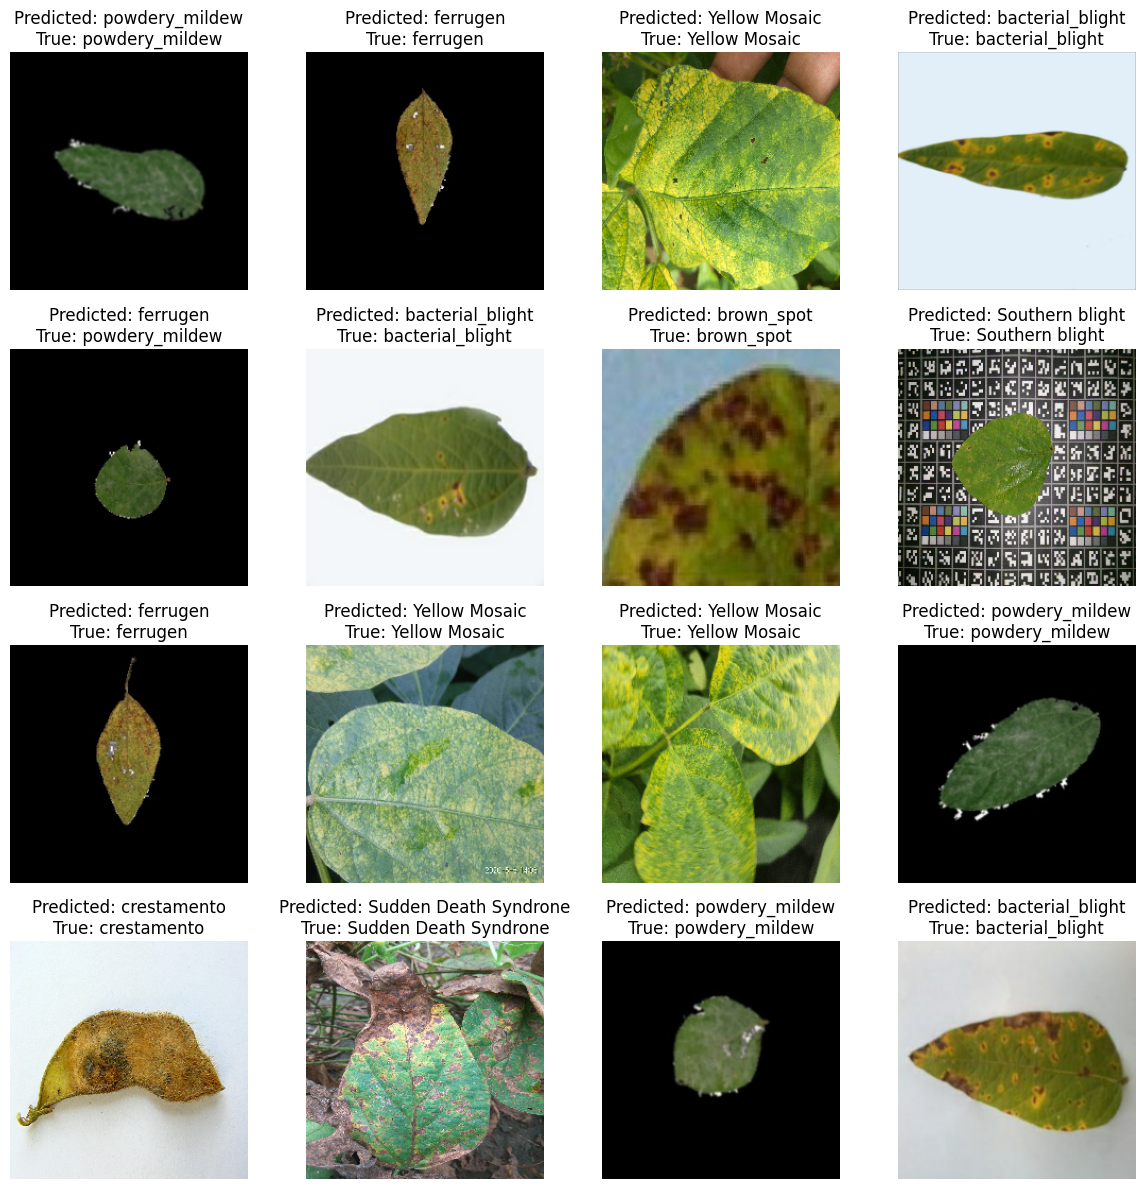

In [16]:
num_rows = 4
num_cols = 4
plt.figure(figsize=(12, 12))

for images, labels in validation_dataset:
    images_normalized = normalization(images)
    
    predictions = model.predict(images_normalized)
    
    for i in range(images.shape[0]):
        image = images[i].numpy()
        label = labels[i]
        

        predicted_class_index = tf.argmax(predictions[i])
        predicted_class_name = class_names[predicted_class_index]
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.title(f"Predicted: {predicted_class_name}\nTrue: {class_names[tf.argmax(label)]}")
        plt.axis("off")
        
        if i == num_rows * num_cols - 1:
            break

    plt.tight_layout()
    plt.show()
    
    if i == num_rows * num_cols - 1:
        break



# InceptionV3 vs ResNet50

The obtained accuracy of ResNet50 (see the notebook https://www.kaggle.com/code/zadosaadipurwanto/resnet50-v2-classification) with training-validation split of 0.8-0.2 is 0.9214285612106323, while in this case, with a training-validation split of 0.85-0.25 and longer training rounds, the accuracy is:

In [17]:
results[1]

0.9047619104385376

Furthermore, the ResNet50 network has half the number of trainable parameters (221k vs 500k) compared to the InceptionV3 network used here. 